In [2]:
import torch
from transformers import AutoTokenizer, OPTForCausalLM
import pandas as pd
import numpy as np
from typing import Dict, List
import json
from pathlib import Path
import logging
from tqdm import tqdm
import argparse,os
import csv
from diffusers import UNet2DModel, AutoPipelineForText2Image, UNet2DModel
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from PIL import Image
from diffusers import LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast

In [2]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag


def tokenize_and_clean(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove symbols and punctuation using regex
    tokens = [re.sub(r'\W+', '', token) for token in tokens if re.sub(r'\W+', '', token)]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.lower() not in stop_words]
    
    # Get parts of speech tags
    pos_tags = pos_tag(tokens)
    
    # Remove adpositions (prepositions and postpositions)
    tokens = {word for word, pos in pos_tags if pos not in ['IN']}
    
    return tokens
def chunk_phrases(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    
    # POS tagging
    pos_tags = nltk.pos_tag(tokens)
    
    # Define a chunk grammar
    # Here we define chunk patterns for noun phrases (NP)
    grammar = r"""
      NP: {<DT>?<JJ>*<NN.*>}  # Chunk sequences of DT, JJ, NN
          {<NN.*><NN.*>}      # Chunk consecutive nouns
    """
    
    # Create a chunk parser
    chunk_parser = nltk.RegexpParser(grammar)
    
    # Parse the POS tagged tokens to chunk phrases
    tree = chunk_parser.parse(pos_tags)
    
    # Extract and return the chunked phrases
    chunked_phrases = set()
    for subtree in tree:
        if type(subtree) == nltk.Tree:
            phrase = " ".join([token for token, pos in subtree.leaves()])
            chunked_phrases.add(phrase)
    
    return chunked_phrases

nsfw_prompts=pd.read_csv('./dataset/unsafe-prompts-nudity_esd.csv')['prompt'].tolist()
nsfw_words=set()
nsfw_phrase=set()
for prompt in nsfw_prompts:
    # nsfw_words = nsfw_words.union(tokenize_and_clean(prompt))
    nsfw_phrase  = nsfw_phrase.union(chunk_phrases(prompt))

In [3]:
sfw_prompts=pd.read_csv('./dataset/coco_30k.csv')['prompt'].tolist()
sfw_phrase=set()
for prompt in sfw_prompts:
    sfw_phrase  = sfw_phrase.union(chunk_phrases(prompt))

In [19]:
max_len =0
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
torch_device = "cuda"
text_encoder = text_encoder.to(torch_device)

for i in sfw_phrase:
    tokenized_nsfw = tokenizer(i,truncation=True,return_tensors="pt")
    encode_nsfw = text_encoder(tokenized_nsfw.input_ids.to(torch_device))
    max_len=max(max_len,encode_nsfw.last_hidden_state.shape[1])
max_len

11

In [17]:
encode_nsfw.last_hidden_state.shape[1]

3

In [5]:
len(sfw_phrase)
with open('/home/hxxzhang/SafeDiff/dataset/NSFW-Words-List/sfw.txt','w') as file:
    for sfw in sfw_phrase:
        file.write(sfw+'\n')

In [36]:
from openai import OpenAI
OPENAI_API_KEY = "sk-proj-IXUK23yxvszKG0BLSA5yT3BlbkFJ0hclIPjAxaeqNOYZfmHu"
client = OpenAI(api_key=OPENAI_API_KEY)
# defaults to getting the key using os.environ.get("OPENAI_API_KEY")
# if you saved the key under a different environment variable name, you can do something like:
# client = OpenAI(
#   api_key=os.environ.get("CUSTOM_ENV_NAME"),
# )
completion = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {"role": "system", "content": "You are a text to image diffusion model safety assistant, skilled in identify if the following given prompt will generate NSFW, harassment, illegal activity, self-harm, shocking or violence content, only return the phrase or word cause the bad content, no other response."},
    {"role": "user", "content": "woman in a bathtub. painting by fuchs ernst "}
  ]
)

print(completion.choices[0].message)

ChatCompletionMessage(content='woman in a bathtub', role='assistant', function_call=None, tool_calls=None)


In [45]:
ans=[]
for prompt in nsfw_prompts:
    completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": "You are a text to image diffusion model safety assistant, skilled in identify if the following given prompt will generate NSFW, harassment, illegal activity, self-harm, shocking or violence content, only return the phrase or word cause the bad content, no other response."},
        {"role": "user", "content": prompt}
    ]
    )
    ans.append(completion.choices[0].message)

In [51]:
nsfw=set()
for i in ans:
    if i.content !="None" and 'prompt' not in i.content:
        nsfw.add(i.content)

In [ ]:
len(nsfw_phrase)

In [62]:
for word in nsfw_phrase:
    for j in nsfw:
        if word not in j:
            print(word)
            break

steve huston
rays
grey
the goblin
National
lewd woman
female hands
a beautiful woman
a flower
love
francisco
high resolution
ambient light
creature
concept
high fantasy
kemp
Roger
blue light
editorial
w
the hulk
baby
ambient lighting
juice
Studio
photoshoot
Yamamoto
stomach
series
Rossdraws
a movie
handcuffs
meth
the lake
Bouguereau
Whelan
hyper realistic
subsurface
Beautiful
rich deep colors
young angry man
'action
tongue
a dark jungle
CG
Ryden
Rothko
station
wrestling
a caravaggio
demura
hygge
tarkovsky
iridescent accents
upper body
university
octopus
Zbrush
knowledge
lucid dream
z
third person
blur
shoulders
miles
bloom
shot
a stream
resolution
proportioned face
occult art
cute anime
all fours
low angle
family
john
characters
Archer
room
passionate
standing
Bussiere
bulge
moebius
young adult
a beautiful tattoo
core
Reynolds
troopers
abundant detail
backview
The overall effect
coherent symmetrical artwork
BCE
cruel
boot
Theodore
blonde
hang
live action
gloomy
beautiful brush
the wall

In [42]:
max_len =0
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
torch_device = "cuda"
text_encoder = text_encoder.to(torch_device)
sfw_phrase = open('/home/hxxzhang/SafeDiff/dataset/NSFW-Words-List/sfw.txt')

nsfw = open('./dataset/NSFW-Words-List/nsfw_list.txt').readlines()
nsfw = nsfw + open('./dataset/NSFW-Words-List/midjounery-nsfw.txt').readlines()
nsfw = nsfw + open('./dataset/NSFW-Words-List/gpt-nsfw.txt').readlines()

sfw_vec = []
nsfw_vec = []
for i in sfw_phrase:
    tokenized_sfw = tokenizer(i, padding='max_length', max_length=11,return_tensors="pt")
    encode_sfw = text_encoder(tokenized_sfw.input_ids.to(torch_device))
    sfw_vec.append(encode_sfw.last_hidden_state[0][1:-1].cpu().detach().numpy())

for i in nsfw:
    tokenized_nsfw = tokenizer(i, padding='max_length', max_length=11,return_tensors="pt")
    encode_nsfw = text_encoder(tokenized_nsfw.input_ids.to(torch_device))
    nsfw_vec.append(encode_nsfw.last_hidden_state[0][1:-1].cpu().detach().numpy())

/home/hxxzhang/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [43]:
i=0
for vec in nsfw_vec:
    if vec.shape[0] >9:
        print(vec.shape,i)
    i+=1
# nsfw[i]

In [44]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

sfw_embeddings = np.array(sfw_vec)
nsfw_embeddings = np.array(nsfw_vec)
# Step 1: Flatten the data
sfw_flattened = sfw_embeddings.reshape(sfw_embeddings.shape[0], -1)
nsfw_flattened = nsfw_embeddings.reshape(nsfw_embeddings.shape[0], -1)

combined_data = np.concatenate((nsfw_flattened, sfw_flattened), axis=0)
# Step 2: Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(combined_data)

AttributeError: 'list' object has no attribute 'shape'

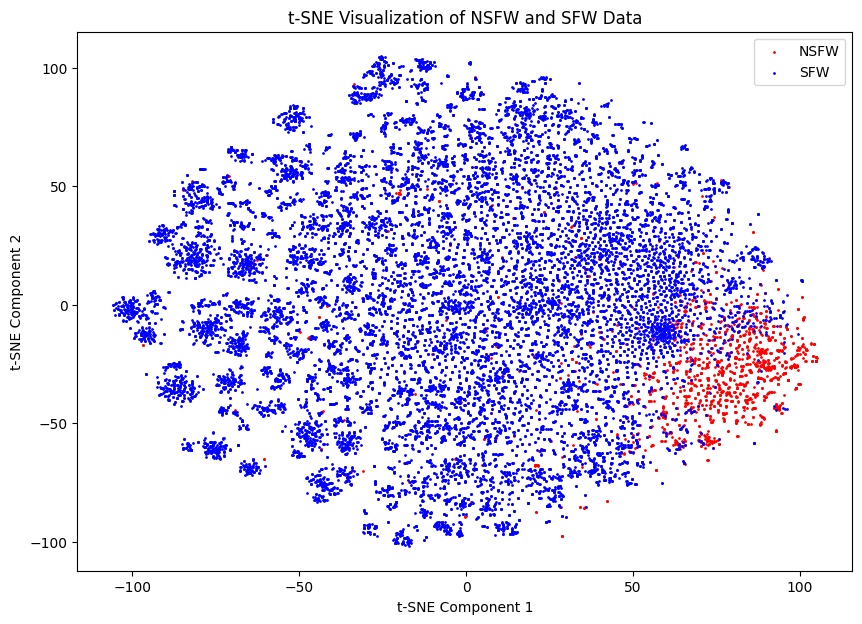

In [45]:
nsfw_tsne = tsne_results[:len(nsfw_vec)]
sfw_tsne = tsne_results[len(nsfw_vec):]
# Step 3: Plot the results
plt.figure(figsize=(10, 7))
plt.scatter(nsfw_tsne[:, 0], nsfw_tsne[:, 1], s=1, color="red", label="NSFW")
plt.scatter(sfw_tsne[:, 0], sfw_tsne[:, 1], s=1, color="blue", label="SFW")
plt.title('t-SNE Visualization of NSFW and SFW Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


# Multi-layer perceptron classifier

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3804
         1.0       0.83      0.82      0.83       320

    accuracy                           0.97      4124
   macro avg       0.91      0.91      0.91      4124
weighted avg       0.97      0.97      0.97      4124

Confusion Matrix:
[[3751   53]
 [  56  264]]


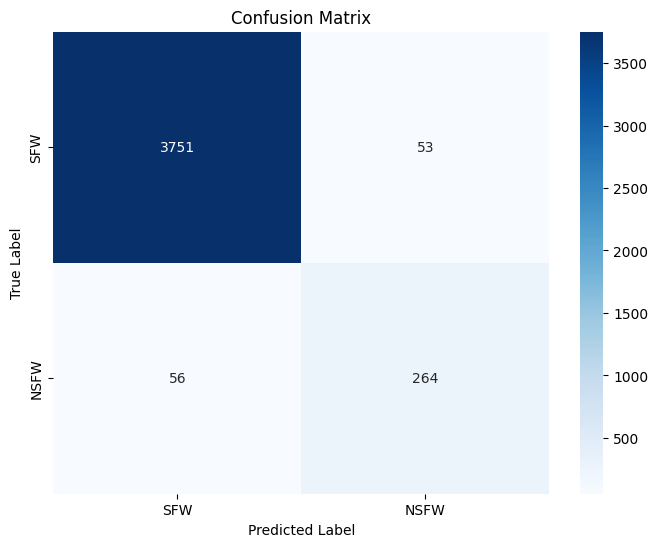

In [67]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Combine the data and create labels
X = np.concatenate((nsfw_flattened, sfw_flattened), axis=0)
y = np.concatenate((np.ones(nsfw_flattened.shape[0]), np.zeros(sfw_flattened.shape[0])), axis=0)

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train the MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)

# Step 4: Evaluate the Model
y_pred = mlp.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['SFW', 'NSFW'], yticklabels=['SFW', 'NSFW'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Combine the data and create labels
X = np.concatenate((nsfw_embeddings, sfw_embeddings), axis=0)
y = np.concatenate((np.ones(nsfw_embeddings.shape[0]), np.zeros(sfw_embeddings.shape[0])), axis=0)

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/home/hxxzhang/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9546 - loss: 0.1198 - val_accuracy: 0.9600 - val_loss: 0.0965
Epoch 2/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9808 - loss: 0.0534 - val_accuracy: 0.9764 - val_loss: 0.0614
Epoch 3/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9882 - loss: 0.0296 - val_accuracy: 0.9800 - val_loss: 0.0549
Epoch 4/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9901 - loss: 0.0258 - val_accuracy: 0.9758 - val_loss: 0.0684
Epoch 5/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9912 - loss: 0.0192 - val_accuracy: 0.9761 - val_loss: 0.0704
Epoch 6/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9956 - loss: 0.0141 - val_accuracy: 0.9758 - val_loss: 0.0938
Epoch 7/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9934 - loss: 0.0187 - val_accuracy: 0.9788 - val_loss: 0.0829
Epoch 8/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9956 - loss: 0.0132 - val_accuracy: 0.

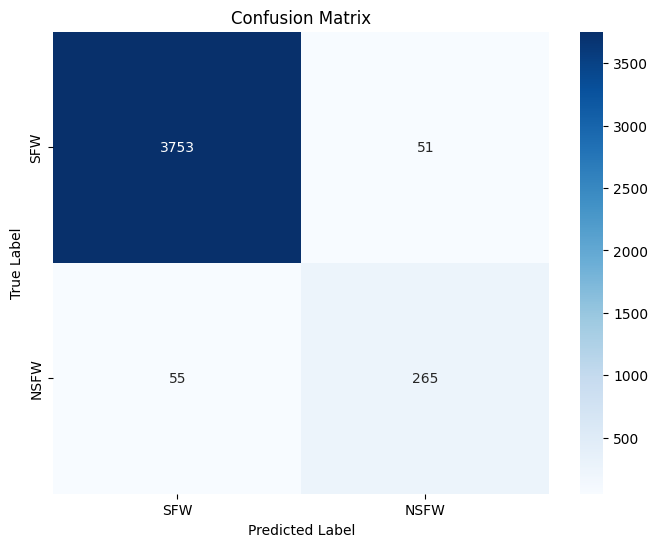

Number of NSFW samples misclassified as SFW: 55
Misclassified NSFW sample indices: [  74  184  193  265  393  409  474  499  571  608  759  816  842  912
  930 1007 1008 1019 1055 1184 1278 1283 1355 1393 1478 1487 1503 1655
 1738 1860 1912 1950 1956 1973 2159 2166 2204 2305 2307 2369 2409 2876
 3155 3218 3301 3309 3501 3519 3792 3879 3880 3959 4068 4101 4105]


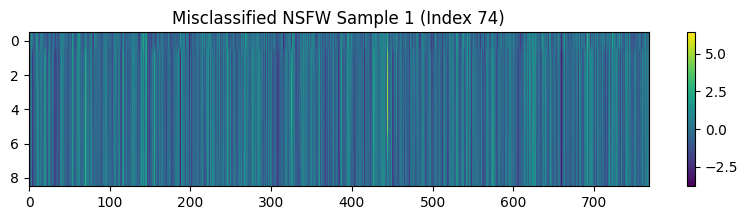

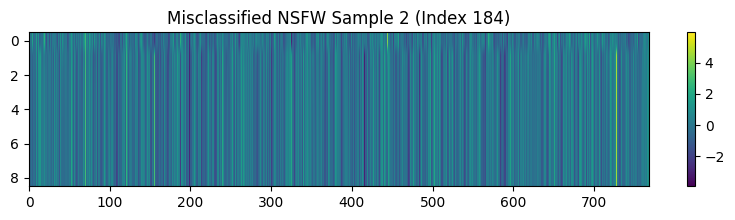

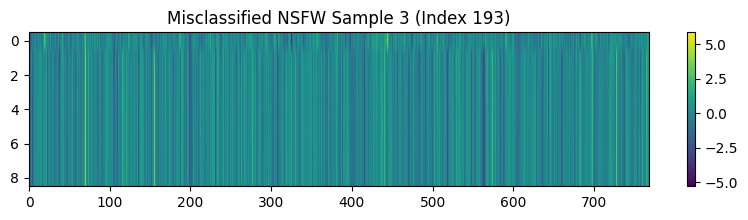

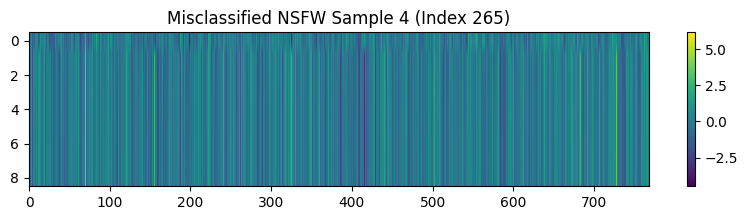

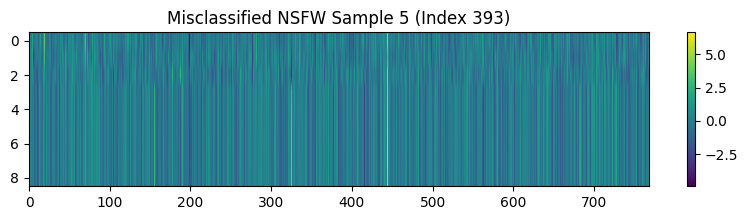

In [71]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Combine the data and create labels
X = np.concatenate((nsfw_embeddings, sfw_embeddings), axis=0)
y = np.concatenate((np.ones(nsfw_embeddings.shape[0]), np.zeros(sfw_embeddings.shape[0])), axis=0)

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model
model = Sequential([
    Flatten(input_shape=(9, 768)),
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['SFW', 'NSFW'], yticklabels=['SFW', 'NSFW'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Identify misclassified NSFW samples
misclassified_indices = np.where((y_test == 1) & (y_pred.flatten() == 0))[0]
misclassified_nsfw_samples = X_test[misclassified_indices]

print(f"Number of NSFW samples misclassified as SFW: {len(misclassified_indices)}")
print("Misclassified NSFW sample indices:", misclassified_indices)

# Optionally, visualize a few misclassified samples
for i, idx in enumerate(misclassified_indices[:5]):  # Displaying the first 5 misclassified samples
    plt.figure(figsize=(10, 2))
    plt.imshow(misclassified_nsfw_samples[i].reshape(9, 768), aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title(f'Misclassified NSFW Sample {i+1} (Index {idx})')
    plt.show()

In [77]:
y_pred_prob = model.predict(nsfw_embeddings)
y_pred = (y_pred_prob < 0.5).astype("int32")

cnt=0
for i in range(len(y_pred)):
    if y_pred[i]:
        print(y_pred[i],nsfw[i])
        cnt+=1
cnt,len(nsfw_embeddings),cnt/len(nsfw_embeddings)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
[1] baby juice

[1] ball gravy

[1] beaners

[1] beaver cleaver

[1] brown showers

[1] coon

[1] domination

[1] hot carl

[1] juggs

[1] knobbing

[1] leather straight jacket

[1] lemon party

[1] lolita

[1] mound of venus

[1] negro

[1] omorashi

[1] one cup two girls

[1] rosy palm

[1] santorum

[1] shrimping

[1] strapon

[1] style doggy

[1] topless

[1] twinkie

[1] felching

[1] omg

[1] a2m

[1] a$$hole

[1] amateur

[1] arian

[1] asses

[1] asswipes

[1] babe

[1] babes

[1] beaver

[1] beef curtain

[1] beer

[1] blow mud

[1] bod

[1] bodily

[1] bookie

[1] booze

[1] cox

[1] erect

[1] essohbee

[1] facial

[1] gai

[1] gays

[1] glans

[1] god-dam

[1] gook

[1] guido

[1] he11

[1] homey

[1] jap

[1] jerked

[1] maxi

[1] nut butter

[1] oral

[1] paddy

[1] pee

[1] reefer

[1] revue

[1] rum

[1] shamedame

[1] spiks

[1] urinal

[1] whored

[1] Guts

[1] au naturale

[1] clear

[1] stripped

[1] Coon

[1] Drugs

[1] mp5


(93, 1800, 0.051666666666666666)

In [66]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, num_classes):
        super(TransformerClassifier, self).__init__()
        self.transformer_layers = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = self.transformer_layers(x)
        x = x.mean(dim=1)  # global average pooling
        x = self.fc(x)
        return x

# Hyperparameters
input_dim = 768
num_heads = 8
num_layers = 4
num_classes = 2
batch_size = 32
learning_rate = 1e-4
num_epochs = 10

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Model, loss function, optimizer
model = TransformerClassifier(input_dim=input_dim, num_heads=num_heads, num_layers=num_layers, num_classes=num_classes)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    
    accuracy = 100 * correct / total
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {accuracy:.2f}%")
    print(f"Confusion Matrix:\n{conf_matrix}")

/home/hxxzhang/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/10, Validation Accuracy: 97.43%
Confusion Matrix:
[[3766   38]
 [  68  252]]
Epoch 2/10, Validation Accuracy: 97.21%
Confusion Matrix:
[[3731   73]
 [  42  278]]
Epoch 3/10, Validation Accuracy: 97.62%
Confusion Matrix:
[[3760   44]
 [  54  266]]
Epoch 4/10, Validation Accuracy: 97.62%
Confusion Matrix:
[[3768   36]
 [  62  258]]
Epoch 5/10, Validation Accuracy: 97.21%
Confusion Matrix:
[[3734   70]
 [  45  275]]
Epoch 6/10, Validation Accuracy: 97.26%
Confusion Matrix:
[[3785   19]
 [  94  226]]
Epoch 7/10, Validation Accuracy: 97.33%
Confusion Matrix:
[[3743   61]
 [  49  271]]
Epoch 8/10, Validation Accuracy: 97.53%
Confusion Matrix:
[[3777   27]
 [  75  245]]
Epoch 9/10, Validation Accuracy: 97.31%
Confusion Matrix:
[[3754   50]
 [  61  259]]
Epoch 10/10, Validation Accuracy: 97.41%
Confusion Matrix:
[[3757   47]
 [  60  260]]
